In [51]:
import gzip
import io
import pandas as pd
import bioframe as bf
import matplotlib.pyplot as plt
import numpy as np
import math

In [2]:
def is_gzip(file_path):
    with open(file_path, 'rb') as file:
        return file.read(2) == b'\x1f\x8b'

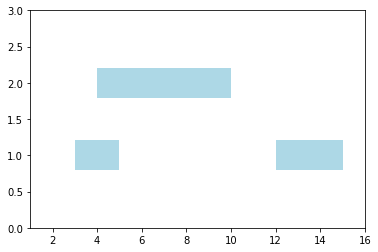

In [62]:
def plot_intervals(bed):
    """Assumes sorted intervals
    
    bed is a pandas datafram with at least the columns chrom, start and end
    """
    assert len(set(bed['chrom']))==1 # check all chromosomes are the same
    
    intervals = list(zip(bed['start'], bed['end']))
    layers = [[intervals[0]]]
    minstart, maxend = intervals[0]
    
    for interval in intervals[1:]:
        
        if interval[0] < minstart: minstart = interval[0]
        if interval[1] > maxend: maxend = interval[1]
        for layer in layers:
            if layer[-1][-1] < interval[0]:
                layer.append(interval)
                break
        else:
            layers.append([interval])

    for i, lay in enumerate(layers):
        x1, x2 = zip(*lay)
        plt.hlines([i + 1] * len(x1), x1, x2, lw=30, color='lightblue')
# To add text. This isn't working yet...
#         print(x1, x2)
#         for bar in zip(x1, x2):
#             print(bar)
#             if text is not None:
#                 plt.text(np.mean(bar), i + 1, 'test', fontsize=12,
#                          horizontalalignment='center', verticalalignment='center', )

    plt.xlim(minstart - 2, maxend + 1)
    plt.ylim(0, len(layers) + 1)

df1 = pd.DataFrame([
    ['chr1', 3, 5],
    ['chr1', 4, 10],
    ['chr1', 12, 15],
    ],
    columns=['chrom', 'start', 'end']
)

plot_intervals(df1)


In [3]:
file_path = 'data/GRCh38.UCSC.SimpleRepeats.tsv.gz'

if is_gzip(file_path):
    bed_file = io.TextIOWrapper(gzip.open(file_path, 'rb'), encoding='utf-8')
else:
    bed_file = open(file_path)
        
bed = pd.read_table(bed_file)
bed.drop(columns='#bin', inplace=True)
bed.rename(columns = {'chromStart':'start', 'chromEnd': 'end'}, inplace=True)
print(bed)
assert bf.core.checks.is_bedframe(bed)

                           chrom      start        end name  period  copyNum  \
0                           chr1   12582784   12583841  trf      57     18.3   
1                           chr1   12582839   12582993  trf       4     37.8   
2                           chr1   12582910   12583333  trf      30     13.5   
3                           chr1   22020082   22020671  trf     308      1.9   
4                           chr1  121609878  121734316  trf     342    365.9   
...                          ...        ...        ...  ...     ...      ...   
1049710  chr22_KI270739v1_random      42428      42470  trf       8      5.2   
1049711  chr22_KI270739v1_random      42529      60923  trf     171    107.5   
1049712  chr22_KI270739v1_random      42644      60923  trf     513     35.6   
1049713  chr22_KI270739v1_random      50068      61010  trf     342     32.1   
1049714  chr22_KI270739v1_random      61202      73979  trf     171     74.9   

         consensusSize  perMatch  perIn

In [4]:
bedclusters = bf.cluster(bed, min_dist=None)
bedclusters.head()


,chrom,start,end,name,period,copyNum,consensusSize,perMatch,perIndel,score,A,C,G,T,entropy,sequence,cluster,cluster_start,cluster_end
0,chr1,12582784,12583841,trf,57,18.3,57,66,20,241,22,51,1,24,1.56,TCCATCCATCCATCCATCCATCCATCCATCCATCCCTCCCTCATCT...,3774,12582784,12583892
1,chr1,12582839,12582993,trf,4,37.8,4,75,13,93,21,52,0,25,1.51,TCCA,3774,12582784,12583892
2,chr1,12582910,12583333,trf,30,13.5,30,69,18,218,23,51,1,23,1.57,CATCCATCCATCCACTCACCTACCCCACTC,3774,12582784,12583892
3,chr1,22020082,22020671,trf,308,1.9,307,83,4,774,31,22,27,18,1.97,CTGTAATCCCAGCACTTTGGGAGGCCGAGGCAAGAGGATCACCTGA...,6261,22020082,22020671
4,chr1,121609878,121734316,trf,342,365.9,341,72,8,44205,29,22,19,28,1.98,AAATATCCACTTGCAGATTCTACAAAAAGAGTGTTTCAAAACTGCT...,27737,121609789,121734418


704534
      chrom      start        end name  period  copyNum  consensusSize  \
4      chr1  121609878  121734316  trf     342    365.9            341   
5      chr1  121625511  121734158  trf     171    640.5            171   
6      chr1  121629465  121734418  trf    1866     56.2           1866   
40129  chr1  121609789  121618811  trf     171     53.2            171   
40130  chr1  121610211  121618811  trf    1687      5.1           1684   
40131  chr1  121613599  121616521  trf    1191      2.5           1188   
40132  chr1  121614765  121618832  trf    1866      2.2           1863   
40133  chr1  121618568  121619644  trf     268      4.0            268   
40134  chr1  121619375  121621483  trf     171     12.4            171   
40135  chr1  121621237  121621777  trf     268      2.0            268   
40136  chr1  121621505  121625138  trf     171     21.4            171   
40137  chr1  121622949  121623846  trf     338      2.7            336   
40138  chr1  121625240  1216257

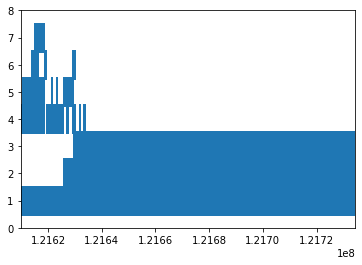

In [39]:
print(len(bedclusters['cluster'].unique()))

i = 0
for cluster in bedclusters['cluster'].unique():
    if i == 2:
        print(bedclusters.loc[bedclusters['cluster'] == cluster])
        plot_intervals(bedclusters.loc[bedclusters['cluster'] == cluster])
        break
    i += 1
    